In [1]:
from tvb.simulator.models.oscillator import Generic2dOscillator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.simulator import Simulator
from tvb.simulator.coupling import Linear
from tvb.simulator.monitors import Raw, TemporalAverage
from tvb.datatypes.connectivity import Connectivity

import matplotlib.pyplot as plt
import numpy as np
import torch
import math
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import arviz as az
from datetime import datetime
%load_ext autoreload
%autoreload 2

/Users/erichter/Documents/Uni/Charite/tvb/tvb-root/scientific_library/tvb/datatypes/surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# Simulation parameters
a_sim = 2.0
b_sim = -10.0
c_sim = 0.0
d_sim = 0.02
I_sim = 0.0
nsig = 0.003
dt = 0.1

In [14]:
# Connectivity
connectivity = Connectivity()
connectivity.weights = np.array([[0., 2/3], [2/3, 0.]])
connectivity.region_labels = np.array(["R1", "R2"])
connectivity.centres = np.array([[0.1, 0.1, 0.1], [0.2, 0.1, 0.1]])
connectivity.tract_lengths = np.array([[0., 0.1], [0.1, 0.]])
connectivity.configure()

# Model
oscillator_model = Generic2dOscillator(
    a=np.asarray([a_sim]),
    b=np.asarray([b_sim]),
    c=np.asarray([c_sim]),
    d=np.asarray([d_sim]),
    I=np.asarray([I_sim]),
)
oscillator_model.configure()

# Integrator
integrator = HeunStochastic(dt=dt)
integrator.noise.nsig = np.array([nsig])
integrator.configure()

# Global coupling
coupling = Linear()

# Monitor
monitor = TemporalAverage()

In [15]:
# Simulator
sim = Simulator(
    model=oscillator_model,
    connectivity=connectivity,
    coupling=coupling,
    integrator=integrator,
    monitors=(monitor,),
    simulation_length=3000
)

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 763ae4ad-22cf-426b-aea6-97b2b7612e65
coupling,Linear gid: 756801b6-0fac-4685-869b-86311b24914c
gid,UUID('ca29eafd-d6d2-4612-aa75-75f973aee798')
initial_conditions,None
integrator,HeunStochastic gid: 2035952d-7b00-468e-943f-b66e7a926e6f
model,Generic2dOscillator gid: 2bcff2b5-5606-4d9c-a102-d96ddd256742
monitors,"(,)"
simulation_length,3000.0


In [16]:
X = np.load("limit-cycle_simulation.npy")

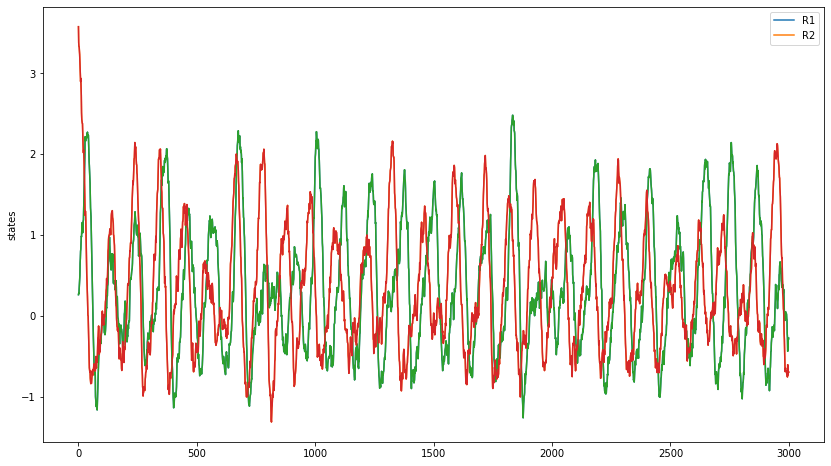

In [32]:
f1 = plt.figure(figsize=(14,8))
plt.plot(X[:, 0, 0, 0], label="R1")
plt.plot(X[:, 0, 1, 0], label="R2")
plt.ylabel("states")
plt.legend()
plt.show()

In [18]:
obs = X

priors = {
    "a": [1.8, 2.2, False],
    "b": [-10.3, -9.7, False],
    "c": [-0.1, 0.1, False],
    "d": [0.01, 0.03, False],
    "I": [-0.1, 0.1, False],
    "epsilon": [0.0, 0.01, False]
}

shape = X.shape

In [19]:
from tvb.contrib.inversion.sbiInference import sbiModel

### SNPE inference

In [34]:
snpe_model = sbiModel(
    simulator_instance=sim,
    method="SNPE", 
    obs=obs, 
    priors=priors,
    obs_shape=shape
)

In [37]:
snpe_model.run_inference(
    num_simulations=200, 
    num_workers=1, 
    num_samples=2000
)

Running 200 simulations.:   0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([200, 6]) torch.Size([200, 6000])
 Neural network successfully converged after 101 epochs.

Drawing 2000 posterior samples:   0%|          | 0/2000 [00:00<?, ?it/s]

2022-07-20 13:00:28,584 - WARNING - root - Only 0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1999 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


KeyboardInterrupt: 

In [41]:
snpe_model.posterior.sample((1,))

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

2022-07-20 13:11:48,391 - WARNING - root - Only 0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


KeyboardInterrupt: 

In [ ]:
inference_data = snpe_model.to_arviz_data(save=True)

In [ ]:
snpe_model.plot_posterior_samples(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": 0.0}
)

In [ ]:
map_estimator = snpe_model.get_map_estimator()
map_estimator

In [ ]:
posterior_sample = snpe_model.get_sample()[0]
posterior_sample

In [ ]:
posterior_obs = snpe_model.simulation_wrapper(params=map_estimator)
posterior_obs = posterior_obs.numpy().reshape(shape, order="F")

In [ ]:
f3 = plt.figure(figsize=(13,8))
plt.plot(snpe_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(snpe_model.inference_data.observed_data.x_obs.values[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
plt.plot(posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
snpe_model.information_criteria()

### SNLE inference

In [ ]:
snle_model = sbiModel(
    integrator_instance=integrator, 
    model_instance=oscillator_model, 
    method="SNLE", 
    obs=obs, 
    priors=priors,
    obs_shape=shape
)

In [ ]:
snle_model.run_inference(
    num_simulations=800,
    num_workers=1,
    num_samples=2000
)

In [ ]:
inference_data = snle_model.to_arviz_data(save=True)

In [ ]:
snle_model.plot_posterior_samples(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": 0.0},
    bins=50
)

In [ ]:
map_estimator = snle_model.get_map_estimator()
map_estimator

In [ ]:
posterior_sample = snle_model.get_sample()[0]
posterior_sample

In [ ]:
posterior_obs = snle_model.simulation_wrapper(params=posterior_sample)
posterior_obs = posterior_obs.numpy().reshape(shape, order="F")

In [ ]:
f4 = plt.figure(figsize=(13,8))
plt.plot(snle_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(snle_model.inference_data.observed_data.x_obs.values[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
plt.plot(posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
snle_model.information_criteria()

### SNRE inference

In [ ]:
snre_model = sbiModel(
    integrator_instance=integrator, 
    model_instance=oscillator_model, 
    method="SNRE", 
    obs=obs, 
    priors=priors,
    obs_shape=shape
)

In [ ]:
snre_model.run_inference(
    num_simulations=800,
    num_workers=1,
    num_samples=2000
)

In [ ]:
inference_data = snre_model.to_arviz_data(save=True)

In [ ]:
snre_model.plot_posterior(
    init_params={"a": a_sim, "b": b_sim, "c": c_sim, "d": d_sim, "I": I_sim, "epsilon": 0.0}
)

In [ ]:
map_estimator = snre_model.get_map_estimator()
map_estimator

In [ ]:
posterior_sample = snre_model.get_sample()[0]
posterior_sample

In [ ]:
posterior_obs = snre_model.simulation_wrapper(params=map_estimator)
posterior_obs = posterior_obs.numpy().reshape(shape, order="F")

In [ ]:
f4 = plt.figure(figsize=(13,8))
plt.plot(snre_model.inference_data.observed_data.x_obs.values[:, 0, 0, 0], label="V_simulated", color="blue")
plt.plot(snre_model.inference_data.observed_data.x_obs.values[:, 1, 0, 0], label="W_simulated", color="red")
plt.plot(posterior_obs[:, 0, 0, 0], label="V_posterior", color="cyan")
plt.plot(posterior_obs[:, 1, 0, 0], label="W_posterior", color="orange")
plt.legend()
plt.xlabel("time (ms)")
plt.ylabel("states")
plt.show()

In [ ]:
snre_model.information_criteria()